In [2]:
import numpy as np
import tensorflow as tf
import helper

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [3]:
tf.__version__
python.__version__

NameError: name 'python' is not defined

In [3]:
PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units * 2

In [4]:
encoder_inputs = tf.placeholder(shape = (None, None), dtype = tf.int32, name = 'encoder_inputs')
encoder_inputs_length = tf.placeholder(shape = (None,), dtype = tf.int32, name = 'encoder_inputs_length')
decoder_targets = tf.placeholder(shape=(None, None), dtype = tf.int32, name = 'decoder_targets')

In [5]:
#Embeddings

embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype = tf.float32)
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

In [6]:
from tensorflow.contrib.rnn import LSTMCell, LSTMStateTuple

In [7]:
((encoder_fw_outputs,
  encoder_bw_outputs),
 (encoder_fw_final_state,
  encoder_bw_final_state)) = (
    tf.nn.bidirectional_dynamic_rnn(cell_fw = LSTMCell(encoder_hidden_units),
                                    cell_bw = LSTMCell(encoder_hidden_units),
                                    inputs = encoder_inputs_embedded, 
                                    sequence_length = encoder_inputs_length, 
                                    dtype = tf.float32, time_major = True)
)

In [8]:
encoder_fw_outputs

<tf.Tensor 'bidirectional_rnn/fw/fw/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 20) dtype=float32>

In [9]:
encoder_bw_outputs

<tf.Tensor 'ReverseSequence:0' shape=(?, ?, 20) dtype=float32>

In [10]:
encoder_fw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 20) dtype=float32>)

In [11]:
encoder_bw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/bw/bw/while/Exit_3:0' shape=(?, 20) dtype=float32>)

In [12]:
encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)
encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)
encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)
encoder_final_state = LSTMStateTuple(
    c = encoder_final_state_c,
    h = encoder_final_state_h
)

In [13]:
#Decoder
decoder_cell = LSTMCell(decoder_hidden_units)

In [14]:
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))

In [15]:
decoder_lengths = encoder_inputs_length +3

In [16]:
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype = tf.float32)
b = tf.Variable(tf.zeros([vocab_size]), dtype = tf.float32)

In [17]:
assert EOS == 1 and PAD ==0

eos_time_slice = tf.ones([batch_size], dtype = tf.int32, name = 'EOS')
pad_time_slice = tf.zeros([batch_size], dtype = tf.int32, name = 'PAD')

eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

In [18]:
def loop_fn_initial():
    initial_elements_finished = (0 >= decoder_lengths)
    initial_input = eos_step_embedded
    initial_cell_state = encoder_final_state
    initial_cell_output = None
    initial_loop_state = None
    return (initial_elements_finished,
           initial_input,
           initial_cell_state,
           initial_cell_output,
           initial_loop_state)

In [19]:
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):
    
    def get_next_input():
        output_logits = tf.add(tf.matmul(previous_output, W), b)
        prediction = tf.argmax(output_logits, axis =1)
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        return next_input
    
    elements_finished = (time >= decoder_lengths)
    
    finished = tf.reduce_all(elements_finished)
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    state = previous_state
    output = previous_output
    loop_state = None
    
    return (elements_finished,
           input,
           state,
           output,
           loop_state)


In [20]:
def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)
    
decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

In [21]:
decoder_outputs

<tf.Tensor 'TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 40) dtype=float32>

In [22]:
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))

In [23]:
decoder_prediction = tf.argmax(decoder_logits, 2)

In [24]:
#optimizer

stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
labels = tf.one_hot(decoder_targets, depth = vocab_size, dtype = tf.float32),
logits = decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [25]:
sess.run(tf.global_variables_initializer())

In [26]:
#training on the Toy task
import helpers
batch_size = 100
batches = helpers.random_sequences(length_from=3, length_to = 8,
                                  vocab_lower =2, vocab_upper = 10,
                                  batch_size = batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[5, 6, 6, 2, 8]
[4, 3, 3, 8, 4, 5]
[4, 9, 4]
[3, 3, 6, 7, 9, 5, 6]
[7, 3, 4, 7, 2, 4]
[8, 9, 2, 2, 5, 4, 2, 7]
[9, 3, 2]
[2, 9, 5, 4, 3, 4, 4]
[9, 9, 4, 8, 8, 7, 5, 6]
[4, 9, 2]


In [27]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, encoder_input_lengths_ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] + [PAD] * 2 for sequence in batch]
    )
    return{
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

In [28]:
loss_track = []

In [29]:
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)
        
        if batch == 0 or batch % batches_in_epoch ==0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}'.format(i+1))
                print('    input    > {}'.format(inp))
                print('    predicted> {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.396998882293701
  sample 1
    input    > [2 4 4 3 7 0 0 0]
    predicted> [9 3 3 3 3 3 3 3 0 0 0]
  sample 2
    input    > [8 2 8 7 9 0 0 0]
    predicted> [9 5 5 0 5 0 6 7 0 0 0]
  sample 3
    input    > [3 5 5 3 8 2 8 3]
    predicted> [4 4 4 4 4 4 4 4 4 4 5]

batch 1000
  minibatch loss: 0.4686514437198639
  sample 1
    input    > [4 7 4 7 6 2 8 0]
    predicted> [4 7 4 7 6 2 8 1 0 0 0]
  sample 2
    input    > [5 6 5 4 5 0 0 0]
    predicted> [5 6 5 4 5 1 0 0 0 0 0]
  sample 3
    input    > [8 5 9 7 3 6 6 0]
    predicted> [8 5 5 7 3 6 6 1 0 0 0]

batch 2000
  minibatch loss: 0.19290466606616974
  sample 1
    input    > [5 9 2 7 0 0 0 0]
    predicted> [5 9 2 7 1 0 0 0 0 0 0]
  sample 2
    input    > [9 6 2 0 0 0 0 0]
    predicted> [9 6 2 1 0 0 0 0 0 0 0]
  sample 3
    input    > [6 5 6 7 0 0 0 0]
    predicted> [6 5 6 7 1 0 0 0 0 0 0]

batch 3000
  minibatch loss: 0.14538268744945526
  sample 1
    input    > [8 4 5 9 4 0 0 0]
    predicted> [

loss 0.1490 after 300100 examples (batch_size = <tf.Variable 'Variable_2:0' shape=(10,) dtype=float32_ref>)


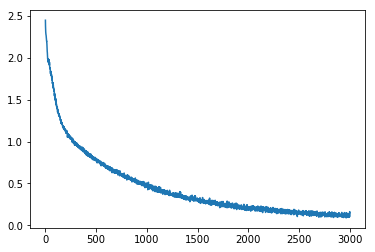

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size = {})'.format(loss_track[-1], len(loss_track)*batch_size, b))